# import các thư viên cần thiết

In [1]:
import open_clip
import torch
import os
import json
import string
import PIL
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import DataLoader

# Chi tiết thí nghiệm

In [14]:
category = 'shirt'
batch_size=16
clip_lr = 1e-6
lr=1e-4
patience = 5
model_name = 'hf-hub:laion/CLIP-ViT-B-16-laion2B-s34B-b88K'
pretrained = None
hidden_dim=512
dropout = 0.5
weight_decay = 0.2

# Xử lý dữ liệu

In [15]:
FashionIQ_path = '/DQU-CIR/data/FashionIQ'
resized_image_path = '/DQU-CIR/data/FashionIQ/resized_image'
captions_path = '/DQU-CIR/data/FashionIQ/captions'
resized_image_category_path = os.path.join(resized_image_path, f"{category}")
list_image = [image.replace('.jpg', '') for image in os.listdir(resized_image_category_path)]
cap_train_path = os.path.join(captions_path, f"cap.{category}.train.json")
with open(cap_train_path) as f:
    raw_cap_train = json.load(f)
cap_train = [item for item in raw_cap_train if (item['target'] in list_image) and (item['candidate'] in list_image)]
cap_val_path = os.path.join(captions_path, f"cap.{category}.val.json")
with open(cap_val_path) as f:
    raw_cap_val = json.load(f)
cap_val = [item for item in raw_cap_val if (item['target'] in list_image) and (item['candidate'] in list_image)]
correction_dict_path = os.path.join(captions_path, f'correction_dict_{category}.json')
with open((correction_dict_path), 'r') as f:
    correction_dict = json.load(f)
image_captions_train_path = os.path.join(captions_path, f"image_captions_{category}_train.json")
with open(image_captions_train_path, 'r') as f:
    image_captions_train = json.load(f)
image_captions_val_path = os.path.join(captions_path, f"image_captions_{category}_val.json")
with open(image_captions_val_path, 'r') as f:
    image_captions_val = json.load(f)
keywords_in_mods_path = os.path.join(captions_path, f'keywords_in_mods_{category}.json')
with open(keywords_in_mods_path, 'r') as f:
    keywords_in_mods = json.load(f)
##################################################################################################################
def correct_text(text, correction_dict):
        trans=str.maketrans({key: ' ' for key in string.punctuation})
        tokens = str(text).lower().translate(trans).strip().split()
        text = " ".join([correction_dict.get(word) if word in correction_dict else word for word in tokens])
        return text
def concat_text(captions, correction_dict):
    caption0 = correct_text(captions[0], correction_dict)
    caption1 = correct_text(captions[1], correction_dict)
    text = f"{caption0} and {caption1}"
    return text
font = PIL.ImageFont.load_default()
def draw_text_line(img, point, text_line: str):
    draw = PIL.ImageDraw.Draw(img)
    lines = text_line.split(", ")
    for i, text in enumerate(lines):
        if text:
            draw_point = (point[0], point[1] + 20 * i)
            draw.text(draw_point, text, font=font, fill=(0, 255, 0))
    return img
##################################################################################################################
def collate_fn(batch, image_captions, resized_image_path, category, keywords_in_mods, preprocess):
    candidate_texts = []; candidate_imgs = []; target_imgs = []
    candidates = []; targets = []
    for item in batch:
        target = item['target']
        candidate = item['candidate']
        # candiate text
        candidate_text = f"{image_captions[candidate]}, but {concat_text(item['captions'], correction_dict)}"
        # candiate image
        key_word = keywords_in_mods[f'{candidate}_{target}'][-1]
        candidate_img_path = os.path.join(resized_image_path, category, f"{candidate}.jpg")
        candidate_img = PIL.Image.open(candidate_img_path).resize((224, 224)) # PIL
        if candidate_img.mode != 'RGB':
            candidate_img = candidate_img.convert('RGB')
        candidate_img = draw_text_line(candidate_img, (32, 32), key_word) # PIL
        candidate_img = preprocess(candidate_img) # tensor 
        # target image
        target_img_path = os.path.join(resized_image_path, category, f"{target}.jpg")
        target_img = PIL.Image.open(target_img_path).resize((224, 224)) # PIL
        if target_img.mode != 'RGB':
            target_img = target_img.convert('RGB')
        target_img = preprocess(target_img) # tensor
        # lưu vào list
        candidate_texts.append(candidate_text); candidate_imgs.append(candidate_img); target_imgs.append(target_img)
        candidates.append(candidate); targets.append(target)
    return {
        'candidate_texts': candidate_texts, 'candidate_imgs': candidate_imgs, 'target_imgs': target_imgs,
        'candidates': candidates, 'targets': targets,
    }
# tạo trainloader, valloader
clip, preprocess_train, preprocess_val = open_clip.create_model_and_transforms(model_name=model_name,pretrained=pretrained)
del clip
trainloader = DataLoader(
    dataset = cap_train,
    batch_size=batch_size, 
    shuffle=True,
    collate_fn=lambda batch: collate_fn(
        batch = batch, 
        image_captions = image_captions_train, 
        resized_image_path = resized_image_path, 
        category = category, 
        keywords_in_mods = keywords_in_mods, 
        preprocess = preprocess_train),
    )
valloader = DataLoader(
    dataset = cap_val,
    batch_size=batch_size, 
    shuffle=True,
    collate_fn=lambda batch: collate_fn(
        batch = batch, 
        image_captions = image_captions_val, 
        resized_image_path = resized_image_path, 
        category = category, 
        keywords_in_mods = keywords_in_mods, 
        preprocess = preprocess_val),
    )

# model

In [16]:
class DQU_CIR(nn.Module):
    def __init__(self, model_name, pretrained, hidden_dim, dropout = 0.5):
        super().__init__()
        self.clip, preprocess_train, preprocess_val = open_clip.create_model_and_transforms(model_name=model_name,pretrained=pretrained)
        del preprocess_train, preprocess_val
        self.tokenizer = open_clip.get_tokenizer(model_name=model_name)
        self.clip = self.clip.float()
        self.loss_weight = torch.nn.Parameter(torch.FloatTensor((10.,)))
        self.combiner_feature = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU())
        self.dropout = nn.Dropout(dropout)
        self.scaler_feature = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid())
        self.cuda()
        # Kiểm tra số lượng tham số của CLIP
        print(f"Số lượng tham số của mô hình CLIP: {sum(p.numel() for p in self.clip.parameters())}")
        # Kiểm tra số lượng tham số của DQU-CIR
        print(f"Tổng số lượng tham số của DQU-CIR: {sum(p.numel() for p in self.parameters())}")
    def extract_img_feature(self, imgs):
        imgs = torch.stack(imgs).cuda()
        return self.clip.encode_image(imgs)
    def extract_text_feature(self, texts):
        texts = self.tokenizer(texts).cuda()
        text_features = self.clip.encode_text(texts)
        return text_features
    def extract_candidate(self, candidate_texts, candidate_imgs):
        candidate_texts = F.normalize(self.extract_text_feature(candidate_texts), p=2, dim=-1)
        candidate_imgs = F.normalize(self.extract_img_feature(candidate_imgs), p=2, dim=-1)
        combined_features = self.combiner_feature(torch.cat([candidate_texts, candidate_imgs], dim=-1))
        dynamic_scalers = self.scaler_feature(self.dropout(combined_features))
        return F.normalize(dynamic_scalers * candidate_texts + (1 - dynamic_scalers) * candidate_imgs, p=2, dim=-1)
    def extract_target(self, target_imgs):
        return F.normalize(self.extract_img_feature(target_imgs), p=2, dim=-1)
    def compute_loss(self, candidate_texts, candidate_imgs, target_imgs):
        candidate_features = self.extract_candidate(candidate_texts, candidate_imgs) 
        target_features = self.extract_target(target_imgs)
        loss = {}
        loss['ranking'] = self.ranking_nce_loss(candidate_features, target_features)                                                                                         
        return loss
    def ranking_nce_loss(self, candidate_features, target_features):
        x = torch.mm(candidate_features, target_features.t())
        loss = F.cross_entropy(self.loss_weight * x, torch.tensor(range(x.shape[0]), device='cuda'))
        return loss
# Khởi tạo mô hình
model = DQU_CIR(model_name, pretrained, hidden_dim, dropout)
# Loss và optimizer
params = list(model.named_parameters())
param_group = [{'params': [p for n, p in params if any(nd in n for nd in ['clip'])], 'lr': clip_lr},
               {'params': [p for n, p in params if not any(nd in n for nd in ['clip'])], 'lr': lr},]
optimizer = torch.optim.AdamW(param_group, lr=lr, weight_decay = weight_decay)

Số lượng tham số của mô hình CLIP: 149620737
Tổng số lượng tham số của DQU-CIR: 150408707


# train

In [12]:
# # Hàm hỗ trợ tạo thư mục lưu kết quả
# def create_experiment_dir(base_dir="/DQU-CIR/results"):
#     os.makedirs(base_dir, exist_ok=True)
#     existing_experiments = [d for d in os.listdir(base_dir) if d.startswith('experiment_')]
#     if existing_experiments:
#         max_experiment = max([int(d.split('_')[-1]) for d in existing_experiments])
#         experiment_id = max_experiment + 1
#     else:
#         experiment_id = 1
#     experiment_dir = os.path.join(base_dir, f"experiment_{experiment_id}")
#     os.makedirs(experiment_dir, exist_ok=True)
#     return experiment_dir
# # Hàm ghi log
# def log_message(message):
#     with open(log_file, 'a') as f:
#         f.write(message + '\n')
#     print(message)
# # Tạo thư mục lưu kết quả
# experiment_dir = create_experiment_dir()
# log_file = os.path.join(experiment_dir, "training_log.txt")
# # Khởi tạo
# num_epochs = 500
# best_loss = float('inf')
# best_epoch = 0
# # Huấn luyện
# for epoch in range(1, num_epochs + 1):
#     model.train()
#     train_loss = 0
#     for batch in tqdm(trainloader, desc=f"Epoch {epoch}/{num_epochs}"):
#         candidate_texts = batch['candidate_texts']
#         candidate_imgs = batch['candidate_imgs']
#         target_imgs = batch['target_imgs']
#         optimizer.zero_grad()
#         loss_dict = model.compute_loss(candidate_texts, candidate_imgs, target_imgs)
#         loss = loss_dict['ranking']
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
#     # log train loss
#     train_loss /= len(trainloader)
#     log_message(f"Epoch {epoch}: Train Loss = {train_loss:.4f}")
#     # Đánh giá trên tập validation
#     model.eval()
#     val_loss = 0
#     with torch.no_grad():
#         for batch in valloader:
#             candidate_texts = batch['candidate_texts']
#             candidate_imgs = batch['candidate_imgs']
#             target_imgs = batch['target_imgs']
#             loss_dict = model.compute_loss(candidate_texts, candidate_imgs, target_imgs)
#             val_loss += loss_dict['ranking'].item()
#     # log val loss
#     val_loss /= len(valloader)
#     log_message(f"Epoch {epoch}: Val Loss = {val_loss:.4f}")
#     # Lưu mô hình nếu tốt hơn
#     if val_loss < best_loss:
#         best_loss = val_loss
#         best_epoch = epoch
#         model_save_path = os.path.join(experiment_dir, f"epoch_{epoch}.pt")
#         torch.save(model.state_dict(), model_save_path)
#         log_message(f"Model saved at {model_save_path}")
#     # Dừng học sớm
#     if epoch - best_epoch >= patience:
#         log_message(f"Early stopping at epoch {epoch}")
#         break
# log_message(f"Training completed. Best Loss = {best_loss:.4f} at epoch {best_epoch}")

# Test

In [17]:
model.load_state_dict(torch.load(f"/DQU-CIR/results/{category}/best.pt"))
model.eval()

/tmp/ipykernel_45451/2037768256.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"/DQU-CIR/results/{category}/best.pt"))


DQU_CIR(
  (clip): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
      (patch_dropout): Identity()
      (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): ModuleList(
          (0-11): 12 x ResidualAttentionBlock(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ls_1): Identity()
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): GELU(approximate='none')
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            )
            (ls_2): Identity()
          )
        )
      )

In [18]:
def get_vector_database(model, resized_image_path, category, preprocess, batch_size):
    vector_database = {}
    resized_image_category_path = os.path.join(resized_image_path, f"{category}")
    list_image = [image.replace('.jpg', '') for image in os.listdir(resized_image_category_path)]
    # Chia danh sách file thành các batch
    batches = [list_image[i:i + batch_size] for i in range(0, len(list_image), batch_size)]
    for batch in tqdm(batches):
        target_imgs = []
        for target in batch:
            target_img_path = os.path.join(resized_image_category_path, f"{target}.jpg")
            target_img = PIL.Image.open(target_img_path).resize((224, 224)) # PIL
            if target_img.mode != 'RGB':
                target_img = target_img.convert('RGB')
            target_img = preprocess(target_img) # tensor
            target_imgs.append(target_img)
        with torch.no_grad():
            target_features = model.extract_target(target_imgs)
        for target, target_feature in zip(batch, target_features):
            vector_database[target] = target_feature
    return vector_database
vector_database = get_vector_database(model, resized_image_path, category, preprocess_val, batch_size)
def get_vector_candidate_targets(model, dataloader):
        vector_candidate_targets = {}
        for batch in tqdm(dataloader):
            with torch.no_grad():
                candidate_features = model.extract_candidate(batch['candidate_texts'], batch['candidate_imgs']) 
            for candidate, target, candidate_feature in zip(batch['candidates'], batch['targets'], candidate_features):
                vector_candidate_targets[f"{candidate}_{target}"] = candidate_feature
        return vector_candidate_targets
vector_candidate_targets = get_vector_candidate_targets(model, valloader)
def get_ranks(vector_database, vector_candidate_targets):
    ranks = []
    database_keys = list(vector_database.keys())  # Lấy danh sách tất cả các target
    database_features = torch.stack([vector_database[key] for key in database_keys])  # Stack thành tensor
    for candidate_target_key, candidate_feature in tqdm(vector_candidate_targets.items()):
        # Tính độ tương đồng cosine giữa candidate và target
        candidate, target = candidate_target_key.split('_')
        candidate_feature = candidate_feature.unsqueeze(0)
        target_feature = vector_database[target].unsqueeze(0)
        similarity_target = torch.mm(candidate_feature, target_feature.t()).item()
        # Tính độ tương đồng giữa candidate và tất cả các vector đã lọc
        mask = torch.tensor([(db_key != candidate and db_key != target) for db_key in database_keys])
        filtered_features = database_features[mask]
        similarities = torch.mm(candidate_feature, filtered_features.t()).squeeze(0)
        # Đếm số vector có similarity lớn hơn similarity của target
        rank = torch.sum(similarities > similarity_target).item() + 1  # Rank bắt đầu từ 1
        ranks.append(rank)
    return ranks
# Tính ranks
ranks = get_ranks(vector_database, vector_candidate_targets)
# Đánh giá mô hình bằng cách tính mAP@K hoặc MRR
import numpy as np
def mean_reciprocal_rank(ranks):
    return np.mean([1.0 / r for r in ranks])
mrr = mean_reciprocal_rank(ranks)
print(f"Mean Reciprocal Rank (MRR): {mrr:.4f}")
def get_recall_at_k(ranks, k):
    correct_at_k = sum(1 for rank in ranks if rank <= k)
    return correct_at_k / len(ranks) * 100
print("R@1 =", get_recall_at_k(ranks, 1))
print("R@10 =", get_recall_at_k(ranks, 10))
print("R@50 =", get_recall_at_k(ranks, 50))

  0%|          | 0/1928 [00:00<?, ?it/s]

100%|██████████| 1940/1940 [00:08<00:00, 235.64it/s]

Mean Reciprocal Rank (MRR): 0.1502
R@1 = 8.969072164948454
R@10 = 27.2680412371134
R@50 = 46.855670103092784


# demo

Query Image:


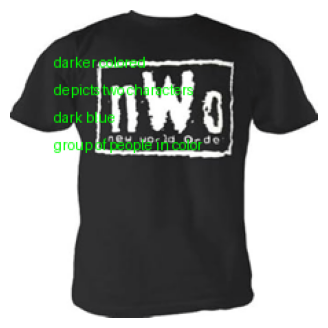

Query Text: the new world order logo t - shirt, but is darker colored and depicts to characters and dark blue and cast group of people in color
Target Image:


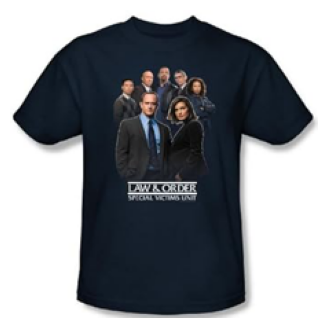

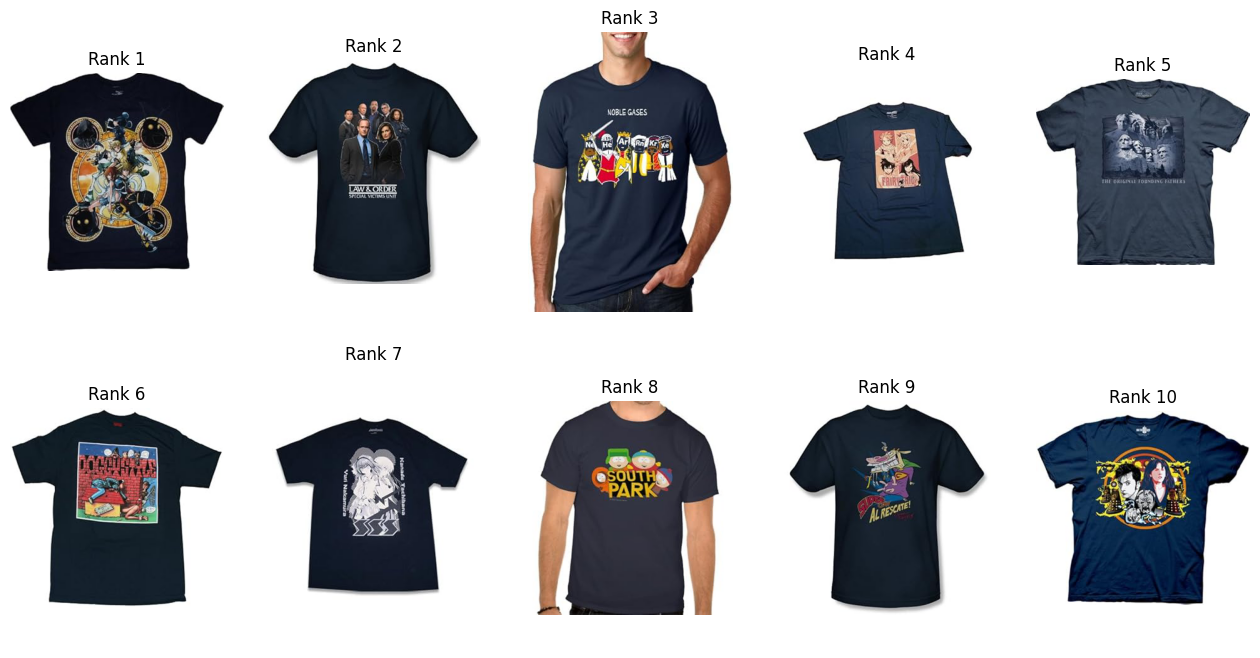

Rank of the target: 2


In [23]:
import matplotlib.pyplot as plt
import torch
import PIL
from PIL import Image
import os
def display_original_image(image_tensor):
    if len(image_tensor.shape) == 3:
        num_channels = image_tensor.shape[0]
        if num_channels == 3:  # Assuming RGB channels
            mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(-1, 1, 1)
            std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(-1, 1, 1)
            denormalized_image = image_tensor.mul(std) + mean
        else:
            raise NotImplementedError("Normalization reversal for non-RGB images not implemented yet")
        denormalized_image = denormalized_image.permute(1, 2, 0).squeeze()  # Rearrange and remove batch dimension
        pil_image = Image.fromarray(denormalized_image.mul(255).byte().numpy())
        plt.figure(figsize=(4, 4))
        plt.imshow(pil_image)
        plt.axis('off')
        plt.show()
    else:
        raise ValueError("Input image tensor must have 3 dimensions (C, H, W)")
batch = next(iter(valloader))
candidate = batch['candidates'][0]
target = batch['targets'][0]

print(f"Query Image:")
display_original_image(batch['candidate_imgs'][0])
print(f"Query Text: {batch['candidate_texts'][0]}")
print(f"Target Image:")
display_original_image(batch['target_imgs'][0])

# Lấy cosine similarity giữa candidate và target
candidate_feature = vector_candidate_targets[f"{candidate}_{target}"].unsqueeze(0)
target_feature = vector_database[target].unsqueeze(0)
similarity_target = torch.mm(candidate_feature, target_feature.t()).item()

# Hiển thị 10 ảnh có độ tương đồng cao nhất
vector_database_keys = [key for key in list(vector_database.keys()) if key != candidate]
vector_database_features = torch.stack([vector_database[key] for key in vector_database_keys])
similarities = torch.mm(candidate_feature, vector_database_features.t()).squeeze(0)
top_10_similarities_idx = torch.argsort(similarities, descending=True)[:10]
plt.figure(figsize=(16, 8))
for i, idx in enumerate(top_10_similarities_idx):
    similar_image_path = os.path.join(resized_image_path, category, f"{vector_database_keys[idx]}.jpg")
    plt.subplot(2, 5, i + 1)
    plt.imshow(PIL.Image.open(similar_image_path))
    plt.axis('off')
    plt.title(f"Rank {i + 1}")
plt.show()

# Xếp hạng vị trí của target trong danh sách các vector
vector_database_keys = [key for key in list(vector_database.keys()) if key != candidate and key != target]
vector_database_features = torch.stack([vector_database[key] for key in vector_database_keys])
similarities = torch.mm(candidate_feature, vector_database_features.t()).squeeze(0)
rank = torch.sum(similarities > similarity_target).item() + 1
print(f"Rank of the target: {rank}")